In [1]:
import numpy as np
import csv
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import random
from scipy.optimize import check_grad
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numdifftools as nd
import collections
import pickle as pkl
from sklearn.calibration import CalibratedClassifierCV
import matplotlib
import warnings
import itertools
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import normalized_mutual_info_score

In [2]:
#parameters

K=10

# Load data

In [4]:
with open('../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
    X,screener_ids,refer_ids,Y_observed,Y_human,Y_service,Y_substantiate,colnames = pkl.load(handle)

In [5]:
file_data = '../../data/ChildWelfare/M_results_Kruns_hybridamalg_logit.pkl'
#file_data = '../../../data/ChildWelfare/M_results_Kruns_hybridamalg_logit.pkl'
with open(file_data, 'rb') as handle:
    M_results = pkl.load(handle)

# Create new output for eval

In [7]:
Y_all = np.array([float(max(Y_observed[i],Y_service[i], Y_substantiate[i])) for i in np.arange(len(Y_service))])

In [11]:
def eval_pred_outcome(idx_25qrtl_pred, Y_outcome, Y_h_test, refer_ids_test, refer_ids):
    
    #outcome labels for subset of test cases that were screened in
    Y_outcome_test = np.array(Y_outcome[[(r in refer_ids_test) for r in refer_ids]])
    Y_outcome_test_scrin = Y_outcome_test[Y_h_test==1]
    
    #baseline
    baseline = sum(Y_outcome_test_scrin)/len(Y_outcome_test_scrin)
    
    #precision and recall in top p% highsest scored screen-in
    precision_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/len(idx_25qrtl_pred)
    recall_p = sum(Y_outcome_test_scrin[idx_25qrtl_pred])/sum(Y_outcome_test)
    
    return baseline, precision_p, recall_p


In [21]:
def eval_pred(Y_pred_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p):
    #identify test sets
    dic_k_Y_pred = {}
    Y_h_test = np.array(Y_human[[(r in refer_ids_test) for r in refer_ids]])
    Y_h_test = np.transpose(Y_h_test)[0]
    
    #Y_pred for subset of cases that were actually screened-in
    Y_pred_test_scrin = Y_pred_test[Y_h_test==1]
    #top p% highest scored screened-in cases 
    idx_25qrtl_pred = np.argsort(Y_pred_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_test_scrin)))]
    
    base_ooh, precision_ooh, recall_ooh = eval_pred_outcome(idx_25qrtl_pred, Y_ooh, Y_h_test, refer_ids_test, refer_ids)
    base_serv, precision_serv, recall_serv = eval_pred_outcome(idx_25qrtl_pred, Y_serv, Y_h_test, refer_ids_test, refer_ids)
    base_sub, precision_sub, recall_sub = eval_pred_outcome(idx_25qrtl_pred, Y_sub, Y_h_test, refer_ids_test, refer_ids)
    
    dic_k_Y_pred['ooh'] = {'base': float(base_ooh), 'precision': float(precision_ooh), 'recall': float(recall_ooh)}
    dic_k_Y_pred['sub'] = {'base': float(base_sub), 'precision': float(precision_sub), 'recall': float(recall_sub)}
    dic_k_Y_pred['serv'] = {'base': float(base_serv), 'precision': float(precision_serv), 'recall': float(recall_serv)}
    
    return dic_k_Y_pred
    
    
    

In [22]:
def eval_k_iter(M_results, Y_h, Y_ooh, Y_serv, Y_sub, p):
    K = len(M_results)
    dic_eval = {}
    
    for k in np.arange(K):
        dic_k = {}
        Y_pred_hybrid_test, Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, refer_ids_train, refer_ids_test = M_results[k]
        dic_k['Y_pred_obs_test'] = eval_pred(Y_pred_obs_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
        dic_k['Y_pred_h_test'] = eval_pred(Y_pred_h_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
        dic_k['Y_pred_hybrid_test'] = eval_pred(Y_pred_hybrid_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
        dic_k['Y_pred_amalg_test'] = eval_pred(Y_pred_amalg_test, Y_h, Y_ooh, Y_serv, Y_sub, refer_ids_test, refer_ids, p)
    
    
        dic_eval[k] = dic_k
    
    return dic_eval

In [23]:
dic_eval_25 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.25)

In [26]:
dic_eval_5 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.05)
dic_eval_10 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.10)
dic_eval_15 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.15)
dic_eval_20 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.20)
dic_eval_30 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.30)
dic_eval_35 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.35)
dic_eval_40 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.40)

In [121]:
dic_eval_40 = eval_k_iter(M_results, Y_human, Y_observed, Y_service, Y_substantiate, 0.40)

In [32]:
dic_eval_5[1]['Y_pred_amalg_test']['ooh']['precision']

0.17450731087094723

In [202]:
def plot_perf_bar(dic_eval, models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(dic_eval.keys())
    
    n_labels = len(labels)
    
    fig, ax = plt.subplots(figsize=(10,5))
    index = np.arange(n_labels)
    bar_width = 0.15
    opacity = 0.8
    colors = ['green', 'darkred', 'yellow', 'blue']
    hatches = ['//', '-', '\\', '.']
    
    
    m_idx =0
    for m in models:
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            if metric == 'precision':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['precision']
            
            if metric == 'recall':
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['recall']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list)  
            l_idx += 1
        rects = plt.bar(index+m_idx*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color=colors[m_idx], capsize=7,  width=.1, hatch = hatches[m_idx],
                            label=plot_labels[m_idx])        
            
            
        m_idx+=1                
    
    
    for n in index[:-1]:
        if metric=='precision':
            t= 0.8
        else:
            t=0.7
        plt.axvline(x=n+t, color='grey', linestyle='--')
        
    if metric=='precision':
        plot_mean = [0]*n_labels
        plot_std = [0]*n_labels
        l_idx = 0
        for l in labels:
            metric_list = [0]*K
            for k in range(K):
                metric_list[k] = dic_eval[k][m][l]['base']
            plot_mean[l_idx] = np.mean(metric_list)  
            plot_std[l_idx] = np.std(metric_list) 
            l_idx +=1
        rects = plt.bar(index+len(models)*bar_width, plot_mean, yerr= plot_std,
            alpha=opacity, color='grey',capsize=7,  width=.1,label='Overall prev.')     

    plt.ylabel(metric,fontsize=25)
    #plt.ylim((0,1.05))
    #plt.title('Performance of outcomes by model',fontsize=18)
    plt.xticks(index + 1.5*bar_width, ('OOH', 'Substantiated', 'Services'),fontsize=18)
    plt.yticks(fontsize=16)
    if legend_appear==True:
        plt.legend(loc = 'upper left', fontsize=18)
    plt.ylim(0.0,y_max)
    plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()

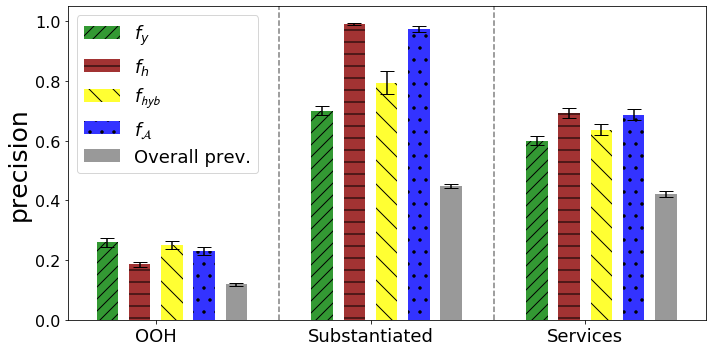

In [203]:
plot_perf_bar(dic_eval_25)

In [210]:
def plot_perf_bar(list_dics, index = np.arange(0.05, 0.4, 0.05), models = ['Y_pred_obs_test', 'Y_pred_h_test',
                                     'Y_pred_hybrid_test', 'Y_pred_amalg_test'], 
                  plot_labels = [ '$f_y$', '$f_h$', '$f_\mathcal{hyb}$',  '$f_\mathcal{A}$' ] ,
                  labels = ['ooh', 'sub', 'serv'], y_max=1.05, legend_appear=True,
                  metric ='precision', fig_title='fig_noname'):
    
    K = len(list_dics[0].keys())
    
    n_groups = len(labels)
    
    fig, ax_list = plt.subplots(1,n_groups, figsize=(14,5))
    N=len(list_dics)
    
    bar_width = 0.1
    opacity = 0.8
    colors = ['green', 'darkred', 'goldenrod', 'blue']
    hatches = ['//', '-', '\\', '.']
    l_idx = 0
    for l in labels:
        m_idx =0
        for m in models:
            plot_mean = [0]*N
            plot_std = [0]*N

            dic_idx = 0
            for dic_eval in list_dics:
                metric_list = [0]*K
                if metric == 'precision':
                    for k in range(K):
                        metric_list[k] = dic_eval[k][m][l]['precision']

                if metric == 'recall':
                    for k in range(K):
                        metric_list[k] = dic_eval[k][m][l]['recall']
                plot_mean[dic_idx] = np.mean(metric_list)  
                plot_std[dic_idx] = np.std(metric_list)  
                dic_idx += 1
            ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
                alpha=opacity, color=colors[m_idx], capsize=7, 
                               label=plot_labels[m_idx])        
#             else:
#                 ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
#                 alpha=opacity, color=colors[m_idx], capsize=7)     

            m_idx+=1                
        

#         for n in index[:-1]:
#             if metric=='precision':
#                 t= (len(list_dics)-1)*bar_width+0.2
#             else:
#                 t= len(list_dics)*bar_width
#             plt.axvline(x=n+t, color='grey', linestyle='--')

        if metric=='precision':
            plot_mean = [0]*N
            plot_std = [0]*N
            dic_idx = 0
            for dic_eval in list_dics:
                metric_list = [0]*K
                for k in range(K):
                    metric_list[k] = dic_eval[k][m][l]['base']
                plot_mean[dic_idx] = np.mean(metric_list)  
                plot_std[dic_idx] = np.std(metric_list) 
                dic_idx +=1
            ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
                alpha=opacity, color='grey',capsize=7, label='base')     
#             else:
#                 ax_list[l_idx].errorbar(index, plot_mean, yerr= plot_std,
#                 alpha=opacity, color='grey',capsize=7)     
        l_idx+=1
        
        
   # plt.ylabel(metric,fontsize=25)
    ax_list[0].set_ylabel(metric,fontsize=20)
    ax_list[1].set_xlabel('top p%',fontsize=20)
    
    for k in range(n_groups):
        ax_list[k].set_title(labels[k],fontsize=20)
    
    
    ax_list[2].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18)
    
    #ax_list[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #  fancybox=True, shadow=True, ncol=5)
    
    #plt.xticks(index+dic_idx*bar_width)
    
#     plt.yticks(fontsize=16)
#     if legend_appear==True:
#         plt.legend(loc = 'upper left', fontsize=18)
    #plt.ylim(0.0,y_max)
    #plt.tight_layout()

#     plt.savefig(fig_title, dpi=300,
#             orientation='portrait' )
    plt.show()

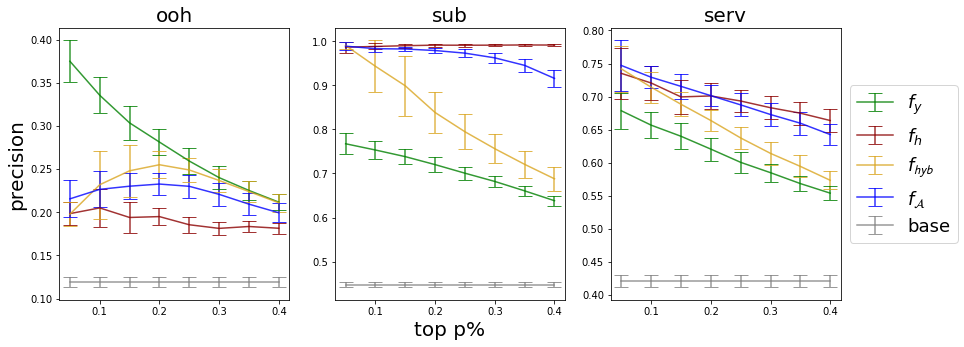

In [211]:
plot_perf_bar([dic_eval_5, dic_eval_10, dic_eval_15, dic_eval_20, dic_eval_25, dic_eval_30, dic_eval_35, dic_eval_40], 
              index = np.arange(0.05, 0.45, 0.05))

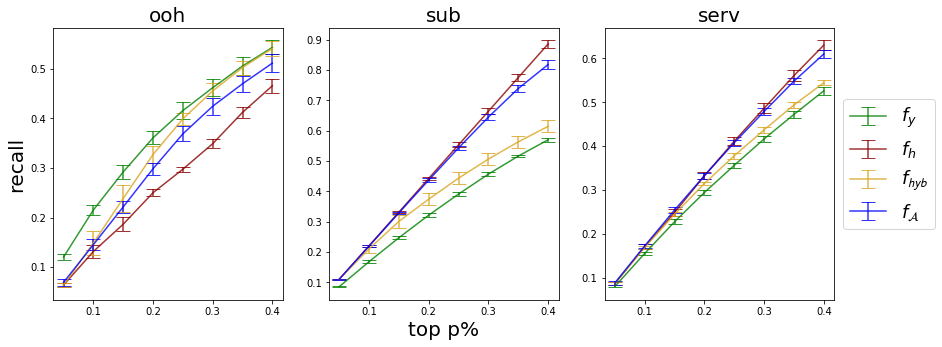

In [212]:
plot_perf_bar([dic_eval_5, dic_eval_10, dic_eval_15, dic_eval_20, dic_eval_25, dic_eval_30, dic_eval_35, dic_eval_40], 
              index = np.arange(0.05, 0.45, 0.05), metric = 'recall')

## Overrides--less likely when amalgamated?

In [213]:
Y_pred_hybrid_test, Y_pred_obs_test, Y_pred_amalg_test, Y_pred_h_test, refer_ids_train, refer_ids_test  = M_results[0]

In [214]:
Y_h_test = np.array(Y_human[[(r in refer_ids_test) for r in refer_ids]])
Y_h_test = np.transpose(Y_h_test)[0]

Y_obs_test = np.array(Y_observed[[(r in refer_ids_test) for r in refer_ids]])
Y_obs_test = np.transpose(Y_obs_test)[0]



In [215]:
Y_obs_test!=Y_pred_amalg_test

array([ True,  True,  True, ...,  True,  True,  True])

In [216]:
Y_pred_amalg_test_scrin = Y_pred_amalg_test[Y_h_test==1]
Y_obs_test_scrin = Y_obs_test[Y_h_test==1]


In [217]:
p=0.45

Y_pred_obs_test_scrin = Y_pred_obs_test[Y_h_test==1]
Y_pred_h_test_scrin = Y_pred_h_test[Y_h_test==1]
Y_pred_amalg_test_scrin = Y_pred_amalg_test[Y_h_test==1]
Y_pred_hybrid_test_scrin = Y_pred_hybrid_test[Y_h_test==1]

Y_obs_test_scrin = Y_obs_test[Y_h_test==1]

        
idx_p_qrtl_pred_obs = np.argsort(Y_pred_obs_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_obs_test_scrin)))]
idx_p_qrtl_pred_amalg = np.argsort(Y_pred_amalg_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_amalg_test_scrin)))]
idx_p_qrtl_pred_hybrid = np.argsort(Y_pred_hybrid_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_hybrid_test_scrin)))]
idx_p_qrtl_pred_human = np.argsort(Y_pred_h_test_scrin)[::-1][:int(np.floor(p*len(Y_pred_h_test_scrin)))]



        
idx_p_qrtl_pred_obs = np.argsort(Y_pred_obs_test)[::-1][:int(np.floor(p*len(Y_pred_obs_test)))]
idx_p_qrtl_pred_amalg = np.argsort(Y_pred_amalg_test)[::-1][:int(np.floor(p*len(Y_pred_amalg_test)))]
idx_p_qrtl_pred_hybrid = np.argsort(Y_pred_hybrid_test)[::-1][:int(np.floor(p*len(Y_pred_hybrid_test)))]
idx_p_qrtl_pred_human = np.argsort(Y_pred_h_test)[::-1][:int(np.floor(p*len(Y_pred_h_test)))]

In [220]:
Y_serv_train = np.array(Y_service[[(r in refer_ids_train) for r in refer_ids]])
Y_serv_test = np.array(Y_service[[(r in refer_ids_test) for r in refer_ids]])

Y_sub_train = np.array(Y_substantiate[[(r in refer_ids_train) for r in refer_ids]])
Y_sub_test = np.array(Y_substantiate[[(r in refer_ids_test) for r in refer_ids]])

In [221]:
sum(Y_h_test[idx_p_qrtl_pred_amalg])/len(idx_p_qrtl_pred_amalg)

0.7332317073170732

In [222]:
sum(Y_h_test[idx_p_qrtl_pred_hybrid])/len(idx_p_qrtl_pred_hybrid)

0.6564405487804879

In [223]:
sum(Y_h_test[idx_p_qrtl_pred_human])/len(idx_p_qrtl_pred_human)

0.7810594512195121

In [224]:
sum(Y_h_test[idx_p_qrtl_pred_obs])/len(idx_p_qrtl_pred_obs)

0.6413871951219512

In [225]:
Y_pred_amalg_test-Y_obs_test

array([ 0.02127383,  0.64813825,  0.15212115, ...,  0.09250847,
       -0.48818644,  0.01822623])

In [226]:
Y_pred_amalg_test_scrin-Y_pred_obs_test_scrin

array([ 0.30777529,  0.23847292,  0.17791639, ...,  0.90831448,
        0.04306931, -0.07838812])

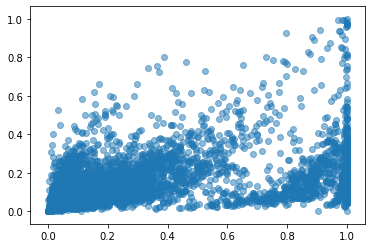

In [227]:
plt.scatter(Y_pred_amalg_test_scrin, Y_pred_obs_test_scrin, alpha=0.5)

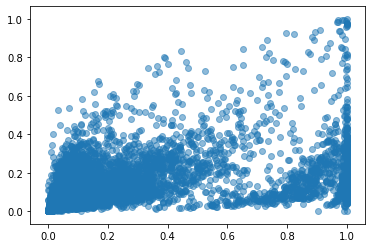

In [228]:
plt.scatter(Y_pred_amalg_test, Y_pred_obs_test, alpha=0.5)

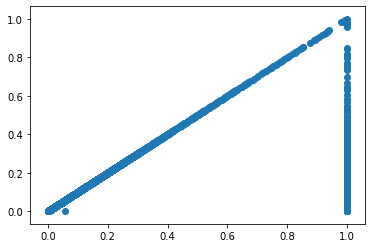

In [229]:
plt.scatter(Y_pred_hybrid_test, Y_pred_obs_test)

In [231]:
Y_pred_h_test_scrin[Y_obs_test]

array([0.99090491, 0.99090491, 0.99090491, ..., 0.99090491, 0.99186924,
       0.99090491])

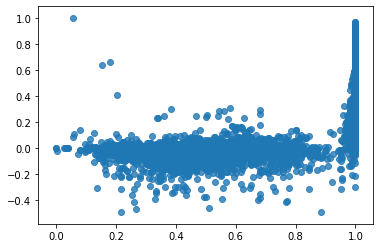

In [232]:
plt.scatter(Y_pred_h_test_scrin, Y_pred_amalg_test_scrin-Y_pred_obs_test_scrin,alpha=0.8)

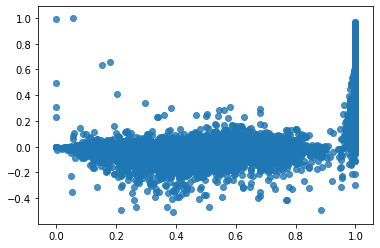

In [233]:
plt.scatter(Y_pred_h_test, Y_pred_amalg_test-Y_pred_obs_test,alpha=0.8)

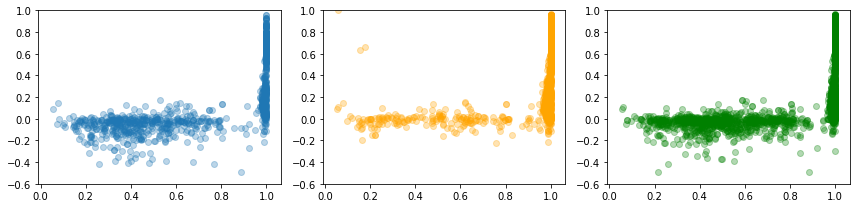

In [234]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axes[0].scatter(Y_pred_h_test[Y_obs_test==1], Y_pred_amalg_test[Y_obs_test==1]-Y_pred_obs_test[Y_obs_test==1],alpha=0.3)
axes[1].scatter(Y_pred_h_test[Y_sub_test==1], Y_pred_amalg_test[Y_sub_test==1]-Y_pred_obs_test[Y_sub_test==1],alpha=0.3, color='orange')
axes[2].scatter(Y_pred_h_test[Y_serv_test==1], Y_pred_amalg_test[Y_serv_test==1]-Y_pred_obs_test[Y_serv_test==1],alpha=0.3, color='green')
axes[0].set_ylim([-0.6,1.0])
axes[1].set_ylim([-0.6,1.0])
axes[2].set_ylim([-0.6,1.0])
#axes[0].ylabel()
fig.tight_layout()


# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))
# plt.scatter(Y_pred_h_test[Y_obs_test==1], Y_pred_amalg_test[Y_obs_test==1]-Y_pred_obs_test[Y_obs_test==1],alpha=0.3, ax=ax1)
# plt.scatter(Y_pred_h_test[Y_sub_test==1], Y_pred_amalg_test[Y_sub_test==1]-Y_pred_obs_test[Y_sub_test==1],alpha=0.3, color='yellow', ax=ax2)
# plt.scatter(Y_pred_h_test[Y_serv_test==1], Y_pred_amalg_test[Y_serv_test==1]-Y_pred_obs_test[Y_serv_test==1],alpha=0.3, color='green', ax=ax3)
# plt.show()

In [292]:
def hist_outcome(Y_plot, Y_outcome, Y_outcome2 = []):
    if  Y_outcome2==[]:
        x = Y_plot[Y_outcome==1]
    else:
        x = [Y_plot[i] for i in range(len(Y_plot)) if Y_outcome[i]==1 and Y_outcome2[i]==1] 
    n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
    plt.axvline(x=0, color='grey', linestyle='--')
    #plt.xlabel('Smarts')
    #plt.ylabel('Probability')
    #plt.title('Histogram of IQ')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(-1.0, 1)
    plt.ylim(0, 4.5)
    #plt.grid(True)
    plt.show()

In [373]:
def hist_outcome(Y_plot, Y_outcome,  legend_1, title_plot='', Y_outcome2 = np.array([]), legend_2=''):
    if  Y_outcome2.size!=0:
        x1 = Y_plot[Y_outcome==1]
        x2 = Y_plot[Y_outcome2==1]
        plt.hist(x1, 60, density=True, facecolor='grey', alpha=0.5, label=legend_1)
        plt.hist(x2, 60, density=True, facecolor='blue', alpha=0.5, label=legend_2)
    else:
        x = Y_plot[Y_outcome==1]
        n, bins, patches = plt.hist(x, 60, density=True, facecolor='g', alpha=0.75, label=legend_1)
    plt.axvline(x=0, color='grey', linestyle='--')
    #plt.xlabel('Smarts')
    #plt.ylabel('Probability')
    #plt.title('Histogram of IQ')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.xlim(-1.0, 1)
    plt.ylim(0, 10.1)
    plt.legend(fontsize=15)
    plt.title(title_plot,fontsize=15)
    #plt.yscale('log')
    #plt.grid(True)
    plt.show()

In [313]:
len(Y_pred_amalg_test)

11664

In [314]:
include_all=np.repeat(1,len(Y_obs_test))

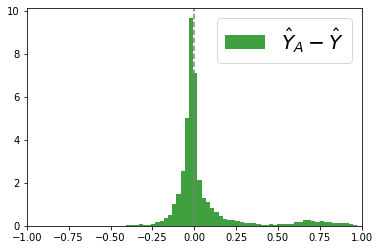

In [370]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test,include_all, '$\hat{Y}_A - \hat{Y}$' )

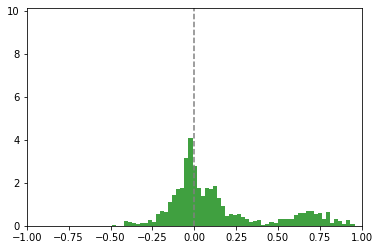

In [344]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, Y_obs_test)

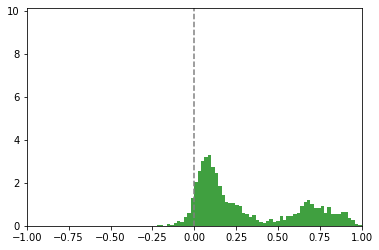

In [345]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, Y_sub_test)

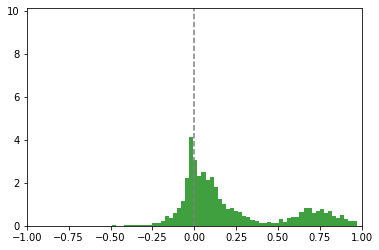

In [346]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, Y_serv_test)

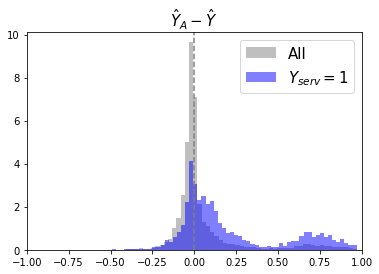

In [375]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, include_all,'All', '$\hat{Y}_A - \hat{Y}$', Y_serv_test,'$Y_{serv}=1$' )

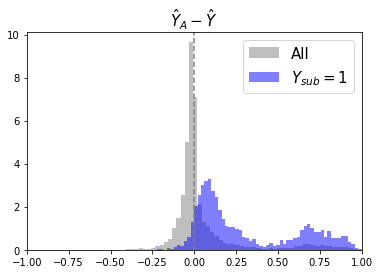

In [376]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, include_all, 'All', '$\hat{Y}_A - \hat{Y}$', Y_sub_test,'$Y_{sub}=1$'  )

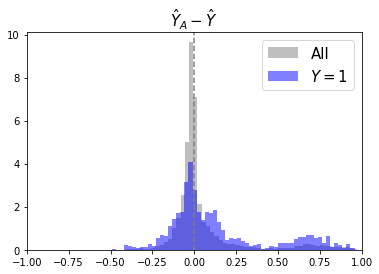

In [377]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, include_all, 'All', '$\hat{Y}_A - \hat{Y}$', Y_obs_test,'$Y=1$'  )

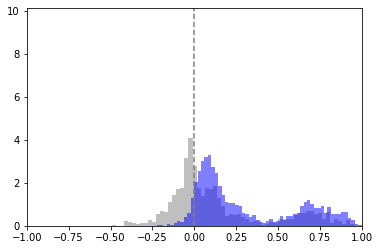

In [354]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, Y_obs_test, Y_sub_test )

/zfsauton2/home/mdeartea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


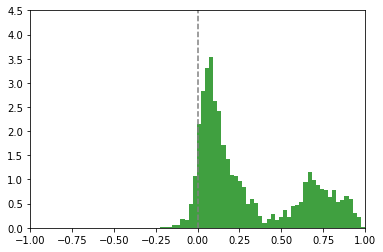

In [300]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, Y_sub_test, 1-Y_obs_test)

/zfsauton2/home/mdeartea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


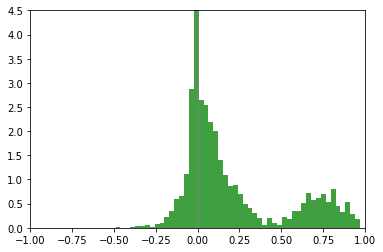

In [301]:
hist_outcome(Y_pred_amalg_test-Y_pred_obs_test, Y_serv_test, 1-Y_obs_test)

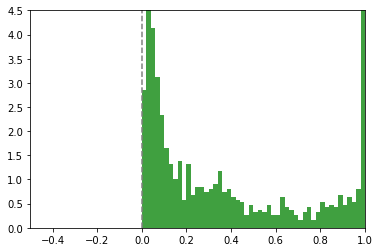

In [284]:
hist_outcome(Y_pred_amalg_test, Y_obs_test)

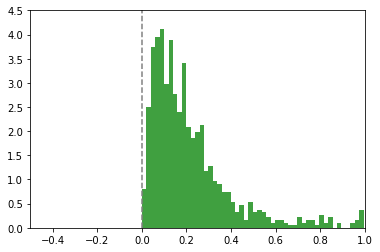

In [287]:
hist_outcome(Y_pred_obs_test, Y_obs_test)

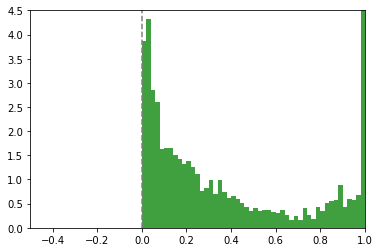

In [285]:
hist_outcome(Y_pred_amalg_test, Y_serv_test)

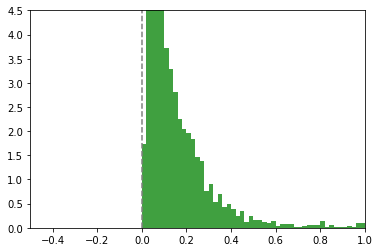

In [286]:
hist_outcome(Y_pred_obs_test, Y_serv_test)